## Analysing model consistency

This notebook reproduces the model-human task consistency correlation analysis from the section _Better performing models are more consistent with humans 430 performance patterns_. Model average performances are calculated _per task_ and their pattern of performance is then correlated with that of humans.

In [2]:
## preamble

# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, sem
import matplotlib.patches as patches
import scipy.stats as st

# define some functions
# define a function to extract a confidence interval range - useful for plotting
def get_CI_range(data, confidence=0.95):
    '''
    Output:
        Difference between the mean and the lower boundary of the 95% CI around the mean.
    '''
    confidence_interval = st.norm.interval(
        alpha=confidence,
        loc=np.mean(data),
        scale=st.sem(data)
    )
    
    interval = np.mean(data) - confidence_interval[0]
    
    return interval

def perf_vec(df, tasks, model = None):
    """
    Output:
        list: the performance vector of a given model across tasks.
    """    
    if model:
        perf_vector = [np.mean(df.loc[(df['task']==t) & (df['model']==model), 'acc'])for t in tasks]
    else:
        perf_vector = [np.mean(df.loc[(df['task']==t), 'acc'])for t in tasks]
    
    return perf_vector

Define some labels and colours for plotting.

In [6]:
# define some labels & information
models_sizes= {'cornet_z': 1562760, 'cornet_V1_V1': 1599880, 'cornet_IT_IT': 3924104, 'CORnet_RT': 4700040, 'TDnet': 8183624, 'FBnet': 11831944, 'cornet_s': 52907720, 'B_net_128': 8291720, 'BL_net_128': 17257864, 'BT_net_128': 12592520, 'BLT_net_128': 21558664, 'vgg11_bn_small': 9426696, 'vgg16_bn': 134301768}
models = ['cornet_z', 'cornet_V1_V1', 'cornet_IT_IT', 'CORnet_RT', 'TDnet', 'FBnet', 'cornet_s', 'B_net_128', 'BL_net_128', 'BT_net_128', 'BLT_net_128', 'vgg11_bn_small', 'vgg16_bn']
models_palette = {'cornet_z': '#E5D5DA', 'cornet_V1_V1': '#D78282', 'cornet_IT_IT': '#ED6E33', 'CORnet_RT': '#F2B0CA', 'TDnet': '#F06599', 'FBnet': '#CA1E49', 'cornet_s': '#B849B5', 'B_net_128': '#D7E6F4', 'BL_net_128': '#97CEE3', 'BT_net_128': '#A5ACD7', 'BLT_net_128': '#4062AE', 'vgg11_bn_small': '#A7D27B', 'vgg16_bn': '#0F9948'}
models_names = {'cornet_z': 'C', 'cornet_V1_V1': 'C V1-V1', 'cornet_IT_IT': 'C IT-IT', 'CORnet_RT': 'CL', 'TDnet': 'CT', 'FBnet': 'CLT', 'cornet_s': 'CS', 'B_net_128': 'B', 'BL_net_128': 'BL', 'BT_net_128': 'BT', 'BLT_net_128': 'BLT', 'vgg11_bn_small': 'VGG11', 'vgg16_bn': 'VGG16'}
tasks = ['control', 'clutter_light', 'clutter_heavy', 'scrambling_highpass', 'scrambling_lowpass', 'occlusion_few_large_deletion_low', 'occlusion_few_large_deletion_high', 'occlusion_few_large_partial_viewing_low', 'occlusion_few_large_partial_viewing_high', 'occlusion_few_large_blobs_high', 'occlusion_few_large_blobs_low', 'occlusion_many_small_deletion_low', 'occlusion_many_small_deletion_high', 'occlusion_many_small_blobs_low', 'occlusion_many_small_blobs_high', 'occlusion_many_small_partial_viewing_low', 'occlusion_many_small_partial_viewing_high']
tasks_names = {'control': 'Control', 'clutter_light': 'Clutter light', 'clutter_heavy': 'Clutter heavy', 'scrambling_highpass': 'High pass', 'scrambling_lowpass': 'Low pass', 'occlusion_few_large_deletion_low': 'FL deletion low', 'occlusion_few_large_deletion_high': 'FL deletion high', 'occlusion_few_large_partial_viewing_low': 'FL occluder low', 'occlusion_few_large_partial_viewing_high': 'FL occluder high', 'occlusion_few_large_blobs_high': 'FL blobs high', 'occlusion_few_large_blobs_low': 'FL blobs low', 'occlusion_many_small_deletion_low': 'MS deletion low', 'occlusion_many_small_deletion_high': 'MS deletion high', 'occlusion_many_small_blobs_low': 'MS blobs low', 'occlusion_many_small_blobs_high': 'MS blobs high', 'occlusion_many_small_partial_viewing_low': 'MS occluder low', 'occlusion_many_small_partial_viewing_high': 'MS occluder high'}

In [7]:
# read the DNN data
nndf = pd.read_csv('../data/nn_data.csv')
# read the human data
hdf = pd.read_csv('../data/human_data.csv')

In [8]:
# extract human performance in a dataframe
humdf = hdf.groupby(['task', 'subj'], as_index=False)['acc'].mean()
# extract human performance vector
hum_perf = perf_vec(humdf, tasks = tasks)

# make the model dataframe with average performance per task and seed
modeldf = nndf.groupby(['model', 'task', 'seed'], as_index=False)['acc'].mean()
# extract models performance vectors
model_perfs = {m: nndf[nndf['model']==m].groupby(['task'])['acc'].mean().reindex(tasks, axis = 0).values
              for m in models}

# make the correlation df between human and model accuracy vectors
corr_df = pd.DataFrame({
    'model': [m for m in models],
    'corr': [pearsonr(hum_perf, model_perfs[m])[0] for m in models],
    'p-value': [pearsonr(hum_perf, model_perfs[m])[1] for m in models],
})

# create the annotation df, whereby I add human performance onto the plots
annotdf = humdf.groupby(['task'], as_index=False)['acc'].mean()
annotdf['low'] = ""
annotdf['high'] = ""
for t in tasks:
    std_mean = sem(humdf.loc[humdf['task']==t, 'acc'].values)
    annotdf.loc[annotdf['task']==t, 'low'] = annotdf.loc[annotdf['task']==t, 'acc'] - std_mean
    annotdf.loc[annotdf['task']==t, 'high'] = annotdf.loc[annotdf['task']==t, 'acc'] + std_mean

## For the correlation plot
# extract models performance vectors per seed
seeds = np.unique(modeldf['seed'])
model_seed_perfs = {
    s: {m:
        [np.mean(modeldf.loc[(modeldf['model']==m) & (modeldf['task']==t) & (modeldf['seed']==s), 'acc'])
            for t in tasks]
        for m in models}
    for s in seeds
}

# make the correlation df with one value per seed
seed_corr_df = pd.DataFrame({
    m: [pearsonr(hum_perf, model_seed_perfs[s][m])[0] for s in seeds]
        for m in models
})

Print some results: correlations between models and human performance patterns.

In [15]:
# print the correlations we calculated
for m in models:
    print(f'{models_names[m]} has a correlation of {np.round(seed_corr_df[m].mean(), 2)} with human pattern of performance.')
# print the overall average correlation
print(f'\nOn average, models have a {np.round(np.mean(seed_corr_df.mean()), 2)} correlation with human task-wise pattern of performance.')

C has a correlation of 0.7 with human pattern of performance.
C V1-V1 has a correlation of 0.65 with human pattern of performance.
C IT-IT has a correlation of 0.75 with human pattern of performance.
CL has a correlation of 0.75 with human pattern of performance.
CT has a correlation of 0.76 with human pattern of performance.
CLT has a correlation of 0.77 with human pattern of performance.
CS has a correlation of 0.79 with human pattern of performance.
B has a correlation of 0.71 with human pattern of performance.
BL has a correlation of 0.76 with human pattern of performance.
BT has a correlation of 0.75 with human pattern of performance.
BLT has a correlation of 0.76 with human pattern of performance.
VGG11 has a correlation of 0.72 with human pattern of performance.
VGG16 has a correlation of 0.85 with human pattern of performance.

On average, models have a 0.75 correlation with human task-wise pattern of performance.


### Plots

Here we reproduce plots from the results section _Better performing models are more consistent with humans 430 performance patterns_. Two plots are made: a large point plot with average performance per task, for models and humans, and a bar plot showing model-wise consistency with humans.

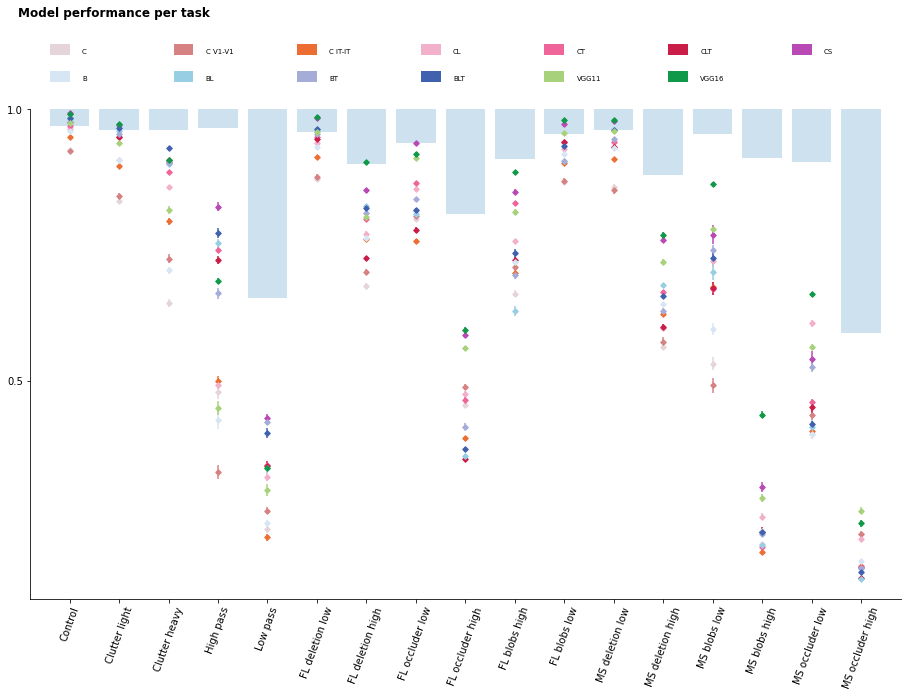

In [23]:
# make a pointplot with model task-wise performance
fig, ax = plt.subplots(1, 1, figsize = (15.6, 9.0))
ax.locator_params(axis = 'y', nbins=2)

for model in models:
    model_data = modeldf[modeldf['model'] == model].groupby(['task', 'seed'], as_index=False)['acc'].mean()
    means = model_data.groupby(['task'], as_index = False).mean()
    # re-order the results based on the order of tasks
    means = means.set_index('task').reindex(index=tasks).reset_index()
    # get the standard errors (SEM)
    stds = model_data.groupby(['task'], as_index = False).sem()
    # re-order that as well
    stds = stds.set_index('task').reindex(index=tasks).reset_index()
    ax.errorbar(x = means['task'],y = means['acc'],yerr=stds['acc'],fmt='D', linestyle=None,
                markersize=4,color = models_palette[model],clip_on = False)

# Change the axes
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim(0.1, 1.0)
ax.set_xticks(ticks = means['task'], labels = tasks_names.values(), rotation = 70)

# Annotate with human performance
for i in range(len(tasks)):
    t = list(tasks)[i]
    y_start = annotdf.loc[annotdf['task']==t, 'acc'].values[0]
    height = 1 - annotdf.loc[annotdf['task']== t, 'low'].values[0]
    ax.add_patch(patches.Rectangle((i - 0.4, y_start), 0.8, height,facecolor = '#CDE1EE',fill=True))

# add a title to the graph
ax.annotate('Model performance per task', (-1.05, 1.17), fontsize = 12.0, fontweight = 'bold', annotation_clip=False)

# add a custom legend
legend_x = 0.1  # X-position for the legend
legend_y = 1.10   # Y-position for the legend
width = 0.4  # Radius of the legend circles
height = 0.02  # Radius of the legend circles
label_offset_x = 0.05  # Offset for the labels from the circles

# Create the legend
for i, label in enumerate(models):
    x, y = (legend_x + i % 7)*2 + ((i%7)*0.5), legend_y - ((i // 7)*0.05)
    ax.add_patch(patches.Rectangle((x-0.6, y), width, height,facecolor = models_palette[label],fill=True,clip_on = False))
    ax.annotate(models_names[label], (x + label_offset_x, y+0.003), ha='left', fontsize=7, annotation_clip=False) 

# remove the top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

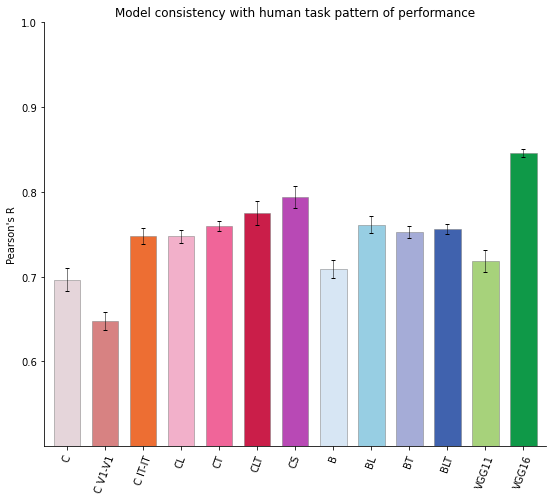

In [22]:
# correlation barplot
fig, ax = plt.subplots(figsize = (9.0, 7.8))
ax.locator_params(axis = 'y', nbins=5)

# define the data to plot
x = seed_corr_df.columns
y = seed_corr_df.mean()
yerr = [
    # get a 95% CI around the data
    get_CI_range(seed_corr_df[c])
    for c in seed_corr_df.columns
]

# Plot them on bars
bars = ax.bar(
    x=x,
    height=y,
    width=0.7,
    color=models_palette.values(),
    yerr = yerr,
    edgecolor='gray',
    linewidth=0.5,
    error_kw=dict(lw=0.5, capsize = 2.0),
)
# Change the axes
max_x = len(models) - 0.4
ax.set_ylim(0.5, 1.0)
ax.set_xlim(-0.6, max_x)
ax.set_xlabel(None)
ax.set_ylabel("Pearson's R")
ax.set_xticks(ticks=seed_corr_df.columns, labels=models_names.values(), rotation=70)
ax.set_yticks(ticks=ax.get_yticks()[1:])

# give a name to the plot
plt.title('Model consistency with human task pattern of performance')

# remove the top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)